In [2]:
import numpy as np
import random
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
import optuna
from torchsummary import summary
import matplotlib.pyplot as plt

#fix random seeds to increase reproducibility
random.seed(23)
np.random.seed(23)

/home/uceezw9/.conda/envs/aml-final/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%cd ..

/home/uceezw9/workplace/github_repo/AMLS_assignment23_24_SN23039407


In [4]:
train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()

In [132]:
class CustomCNN(nn.Module):
    def __init__(self,j):
        super(CustomCNN, self).__init__()

        self.j = j
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding = 1)  # Assuming input channels = 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)


        # Fully connected (Dense) layers
        self.fc1 = nn.Linear(16 * 14 * 14, 16)  # Adjust the input features
        if self.j > 1:
            self.fc1 = nn.Linear(32 * 7 * 7, 16)
        if self.j > 2:
            self.fc1 = nn.Linear(64 * 3 * 3, 16)

        
        self.fc2 = nn.Linear(16, 1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout layers
        self.dropout20 = nn.Dropout(0.20)
        self.dropout25 = nn.Dropout(0.25)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout20(x)
        #print(x.shape)
        if self.j > 1:
            x = self.pool(F.relu(self.conv2(x)))
            x = self.dropout20(x)
        if self.j > 2:
            x = self.pool(F.relu(self.conv3(x)))
            x = self.dropout20(x)
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # Apply second dense layer (output layer)
        #print(x.shape)
        x = torch.sigmoid(self.fc2(x))

        return x

In [133]:
#debug box
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle= True, drop_last=True)

val_accuracy_list = []
model = CustomCNN(j=1)
model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:

        optimizer.zero_grad()
        data = data.cuda()
        output = model(data)
        target = target.float().cuda()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    total_val_loss_epoch = 0
    model.eval()
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for data, target in val_loader:
            data = data.cuda()
            val_output = model(data)
            target = target.cuda()
            val_loss = criterion(val_output, target)
            pred_label = torch.round(val_output)
            num_correct += (pred_label == target).sum().item()
            num_samples += pred_label.size(0)
            total_val_loss_epoch += val_loss

        #calculate the avg validation loss per epoch
        val_loss_epoch_avg=  total_val_loss_epoch/len(val_loader)
        val_accuracy = 100*num_correct / num_samples
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(val_loss_epoch_avg)

Validation Accuracy: 95.7031
tensor(0.1294, device='cuda:0')


In [142]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle= True, drop_last=True)



val_accuracy_total = []
val_loss_total = []
#change j to select models with different structures



def run_model(type):
    val_accuracy_list = []
    val_loss_list = []
    
    model = CustomCNN(j=type)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        total_val_loss_epoch = 0
        model.train()
        for data, target in train_loader:

            optimizer.zero_grad()
            data = data.cuda()
            output = model(data)
            target = target.float().cuda()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        
        model.eval()
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for data, target in val_loader:
                data = data.cuda()
                val_output = model(data)
                target = target.cuda()
                val_loss = criterion(val_output, target)
                pred_label = torch.round(val_output)
                num_correct += (pred_label == target).sum().item()
                num_samples += pred_label.size(0)
                total_val_loss_epoch += val_loss

            val_accuracy = 100*num_correct / num_samples
            val_loss_epoch_avg=  total_val_loss_epoch/len(val_loader)

            val_accuracy_list.append(val_accuracy)            
            val_loss_list.append(val_loss_epoch_avg.cpu())
            
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Validation loss: {val_loss:.2f}")
    val_accuracy_total.append(val_accuracy_list)
    val_loss_total.append(val_loss_list)




In [143]:
for i in range(1,4):
    run_model(i)

Validation Accuracy: 96.09
Validation loss: 0.13
Validation Accuracy: 96.68
Validation loss: 0.05
Validation Accuracy: 96.48
Validation loss: 0.09


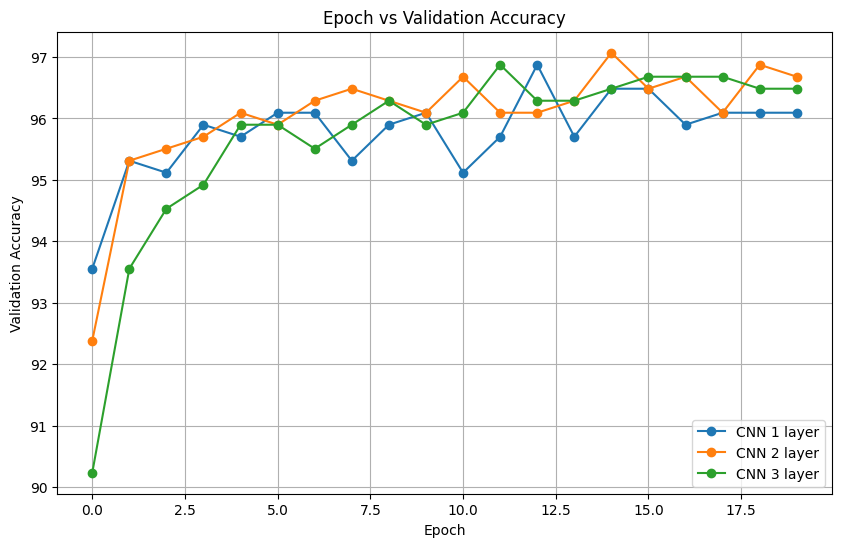

In [144]:
plt.figure(figsize=(10, 6))
names = ["CNN 1 layer","CNN 2 layer","CNN 3 layer"]
for count in range(0,3):
    plt.plot(val_accuracy_total[count], marker='o')
plt.title('Epoch vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(names, loc='lower right')
plt.grid(True)
plt.show()

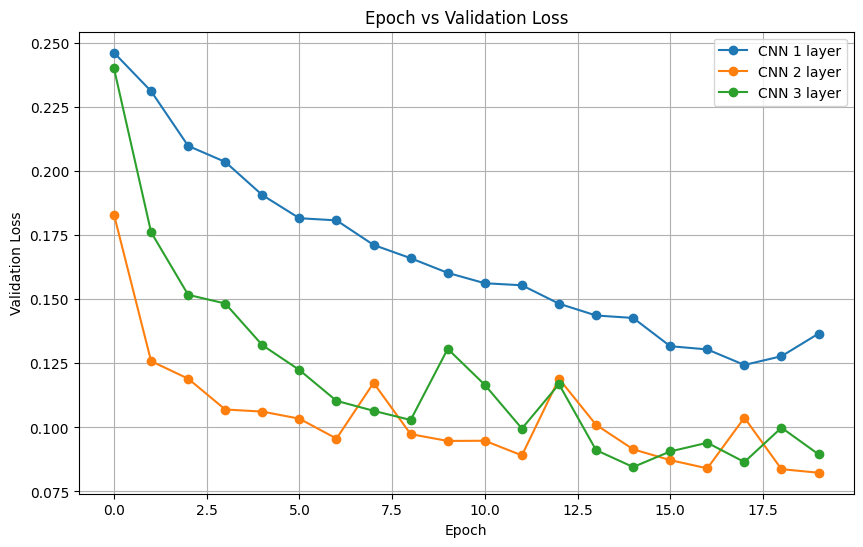

In [145]:
plt.figure(figsize=(10, 6))
names = ["CNN 1 layer","CNN 2 layer","CNN 3 layer"]
for count in range(0,3):
    plt.plot(val_loss_total[count], marker='o')
plt.title('Epoch vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(names, loc='upper right')
plt.grid(True)
plt.show()

*Hypertuning to find out best channels in conv layers*

In [5]:
class CustomCNN(nn.Module):
    def __init__(self,j):
        super(CustomCNN, self).__init__()

        self.j = j
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 8*j, kernel_size=3, stride=1, padding = 1)  # Assuming input channels = 1
        self.conv2 = nn.Conv2d(8*j, 2*8*j, kernel_size=3, stride=1, padding = 1)


        self.fc1 = nn.Linear( 2*8*j * 7 * 7, 16)

        self.fc2 = nn.Linear(16, 1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout layers
        self.dropout20 = nn.Dropout(0.20)
        self.dropout25 = nn.Dropout(0.25)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout20(x)
        #print(x.shape)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout20(x)

        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # Apply second dense layer (output layer)
        #print(x.shape)
        x = torch.sigmoid(self.fc2(x))

        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle= True, drop_last=True)



val_accuracy_total = []
val_loss_total = []
#change j to select models with different structures



def run_model(type):
    val_accuracy_list = []
    val_loss_list = []
    
    model = CustomCNN(j=type)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        total_val_loss_epoch = 0
        model.train()
        for data, target in train_loader:

            optimizer.zero_grad()
            data = data.cuda()
            output = model(data)
            target = target.float().cuda()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        
        model.eval()
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for data, target in val_loader:
                data = data.cuda()
                val_output = model(data)
                target = target.cuda()
                val_loss = criterion(val_output, target)
                pred_label = torch.round(val_output)
                num_correct += (pred_label == target).sum().item()
                num_samples += pred_label.size(0)
                total_val_loss_epoch += val_loss

            val_accuracy = 100*num_correct / num_samples
            val_loss_epoch_avg=  total_val_loss_epoch/len(val_loader)

            val_accuracy_list.append(val_accuracy)            
            val_loss_list.append(val_loss_epoch_avg.cpu())
            
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Validation loss: {val_loss:.2f}")
    val_accuracy_total.append(val_accuracy_list)
    val_loss_total.append(val_loss_list)




In [14]:
for i in range(1,5):
    run_model(i)

Validation Accuracy: 96.09
Validation loss: 0.08
Validation Accuracy: 96.29
Validation loss: 0.17
Validation Accuracy: 97.46
Validation loss: 0.08
Validation Accuracy: 96.48
Validation loss: 0.19


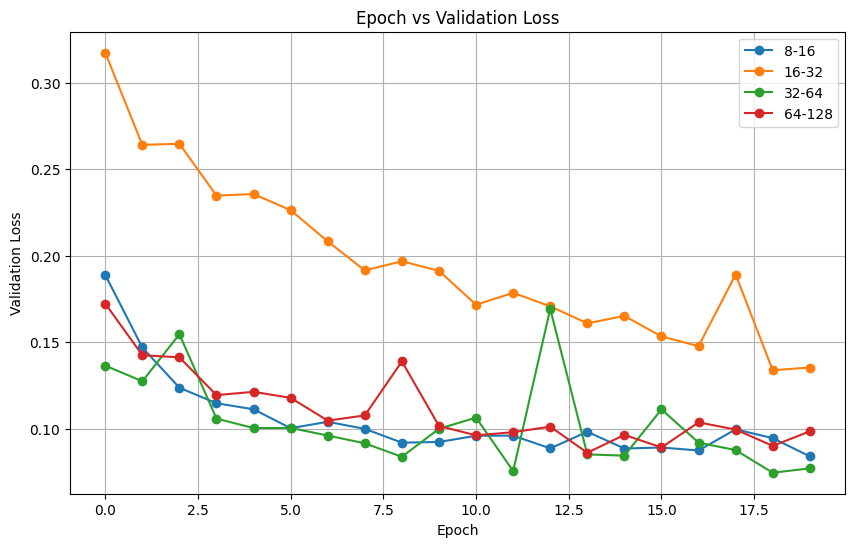

In [17]:
plt.figure(figsize=(10, 6))
names = ["8-16","16-32","32-64","64-128"]
for count in range(0,4):
    plt.plot(val_loss_total[count], marker='o')
plt.title('Epoch vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(names, loc='upper right')
plt.grid(True)
plt.show()

*Hypertune to find out best neuron number in fully connected layer*

In [18]:
class CustomCNN(nn.Module):
    def __init__(self,j):
        super(CustomCNN, self).__init__()

        self.j = j
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding = 1)  # Assuming input channels = 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)


        self.fc1 = nn.Linear( 64 * 7 * 7, 2**(j+3))

        self.fc2 = nn.Linear(2**(j+3), 1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout layers
        self.dropout20 = nn.Dropout(0.20)
        self.dropout25 = nn.Dropout(0.25)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout20(x)
        #print(x.shape)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout20(x)

        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # Apply second dense layer (output layer)
        #print(x.shape)
        x = torch.sigmoid(self.fc2(x))

        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle= True, drop_last=True)



val_accuracy_total = []
val_loss_total = []
#change j to select models with different structures



def run_model(type):
    val_accuracy_list = []
    val_loss_list = []
    
    model = CustomCNN(j=type)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        total_val_loss_epoch = 0
        model.train()
        for data, target in train_loader:

            optimizer.zero_grad()
            data = data.cuda()
            output = model(data)
            target = target.float().cuda()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        
        model.eval()
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for data, target in val_loader:
                data = data.cuda()
                val_output = model(data)
                target = target.cuda()
                val_loss = criterion(val_output, target)
                pred_label = torch.round(val_output)
                num_correct += (pred_label == target).sum().item()
                num_samples += pred_label.size(0)
                total_val_loss_epoch += val_loss

            val_accuracy = 100*num_correct / num_samples
            val_loss_epoch_avg=  total_val_loss_epoch/len(val_loader)

            val_accuracy_list.append(val_accuracy)            
            val_loss_list.append(val_loss_epoch_avg.cpu())
            
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Validation loss: {val_loss:.2f}")
    val_accuracy_total.append(val_accuracy_list)
    val_loss_total.append(val_loss_list)




In [22]:
for i in range(0,4):
    run_model(i)

Validation Accuracy: 96.88
Validation loss: 0.12
Validation Accuracy: 96.48
Validation loss: 0.09
Validation Accuracy: 96.68
Validation loss: 0.13
Validation Accuracy: 97.07
Validation loss: 0.03


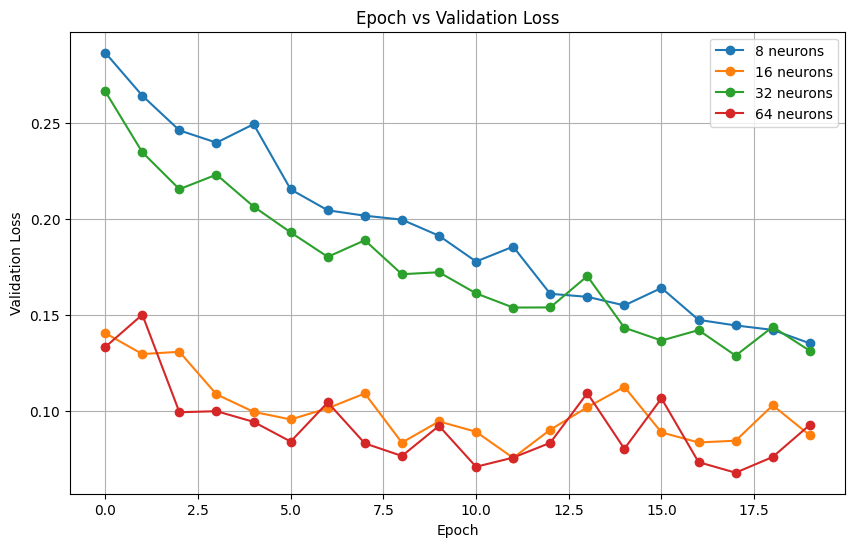

In [23]:
plt.figure(figsize=(10, 6))
names = ["8 neurons","16 neurons","32 neurons","64 neurons"]
for count in range(0,4):
    plt.plot(val_loss_total[count], marker='o')
plt.title('Epoch vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(names, loc='upper right')
plt.grid(True)
plt.show()

*Hypertune dropout rate*

In [26]:
class CustomCNN(nn.Module):
    def __init__(self,j):
        super(CustomCNN, self).__init__()

        self.j = j
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding = 1)  # Assuming input channels = 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)


        self.fc1 = nn.Linear( 64 * 7 * 7, 64)

        self.fc2 = nn.Linear(64, 1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout layers
        self.dropout= nn.Dropout(0.1*j)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        #print(x.shape)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # Apply second dense layer (output layer)
        #print(x.shape)
        x = torch.sigmoid(self.fc2(x))

        return x

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle= True, drop_last=True)



val_accuracy_total = []
val_loss_total = []
#change j to select models with different structures



def run_model(type):
    val_accuracy_list = []
    val_loss_list = []
    
    model = CustomCNN(j=type)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        total_val_loss_epoch = 0
        model.train()
        for data, target in train_loader:

            optimizer.zero_grad()
            data = data.cuda()
            output = model(data)
            target = target.float().cuda()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        
        model.eval()
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for data, target in val_loader:
                data = data.cuda()
                val_output = model(data)
                target = target.cuda()
                val_loss = criterion(val_output, target)
                pred_label = torch.round(val_output)
                num_correct += (pred_label == target).sum().item()
                num_samples += pred_label.size(0)
                total_val_loss_epoch += val_loss

            val_accuracy = 100*num_correct / num_samples
            val_loss_epoch_avg=  total_val_loss_epoch/len(val_loader)

            val_accuracy_list.append(val_accuracy)            
            val_loss_list.append(val_loss_epoch_avg.cpu())
            
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Validation loss: {val_loss:.2f}")
    val_accuracy_total.append(val_accuracy_list)
    val_loss_total.append(val_loss_list)




In [28]:
for i in range(1,5):
    run_model(i)


Validation Accuracy: 95.51
Validation loss: 0.20
Validation Accuracy: 95.51
Validation loss: 0.08
Validation Accuracy: 96.48
Validation loss: 0.06
Validation Accuracy: 97.46
Validation loss: 0.10


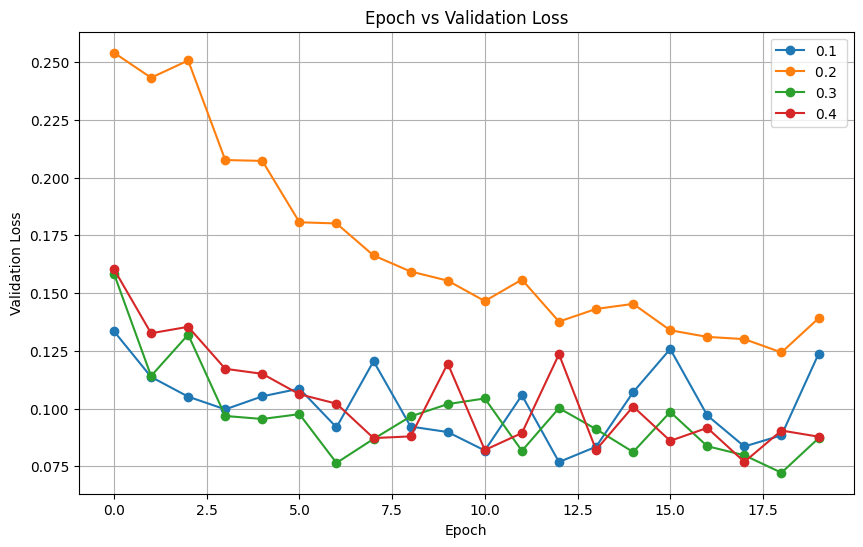

In [29]:
plt.figure(figsize=(10, 6))
names = ["0.1","0.2 ","0.3","0.4"]
for count in range(0,4):
    plt.plot(val_loss_total[count], marker='o')
plt.title('Epoch vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(names, loc='upper right')
plt.grid(True)
plt.show()

*final model*

In [37]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding = 1)  # Assuming input channels = 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)


        self.fc1 = nn.Linear( 64 * 7 * 7, 64)

        self.fc2 = nn.Linear(64, 1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout layers
        self.dropout= nn.Dropout(0.3)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        #print(x.shape)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # Apply second dense layer (output layer)
        #print(x.shape)
        x = torch.sigmoid(self.fc2(x))

        return x

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle= True, drop_last=True)



val_accuracy_total = []
val_loss_total = []
#change j to select models with different structures


val_accuracy_list = []
val_loss_list = []

model = CustomCNN()
model.to(device)

#set placeholder for best model
lowest_val_loss = float('inf')
highest_val_accuracy = 0
best_model_val_loss = None  
best_model_val_acc = None
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_val_loss_epoch = 0
    model.train()
    for data, target in train_loader:

        optimizer.zero_grad()
        data = data.cuda()
        output = model(data)
        target = target.float().cuda()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
    model.eval()
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for data, target in val_loader:
            data = data.cuda()
            val_output = model(data)
            target = target.cuda()
            val_loss = criterion(val_output, target)
            pred_label = torch.round(val_output)
            num_correct += (pred_label == target).sum().item()
            num_samples += pred_label.size(0)
            total_val_loss_epoch += val_loss

        val_accuracy = 100*num_correct / num_samples
        val_loss_epoch_avg=  total_val_loss_epoch/len(val_loader)

        val_accuracy_list.append(val_accuracy)            
        val_loss_list.append(val_loss_epoch_avg.cpu())
        if val_loss_epoch_avg < lowest_val_loss:
            lowest_val_loss = val_loss_epoch_avg
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'A/pretrained_weights_customCNN/best_model_val_loss_j.pth')

        if val_accuracy > highest_val_accuracy:
            highest_val_accuracy = val_accuracy
            best_model_val_acc = model.state_dict()
            torch.save(best_model_val_acc, 'A/pretrained_weights_customCNN/best_model_val_acc_j.pth')
            
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Validation loss: {val_loss:.2f}")
val_accuracy_total.append(val_accuracy_list)
val_loss_total.append(val_loss_list)




Validation Accuracy: 74.41
Validation loss: 0.24
Validation Accuracy: 95.31
Validation loss: 0.14
Validation Accuracy: 94.92
Validation loss: 0.18
Validation Accuracy: 95.70
Validation loss: 0.05
Validation Accuracy: 92.97
Validation loss: 0.16
Validation Accuracy: 95.90
Validation loss: 0.11
Validation Accuracy: 96.29
Validation loss: 0.13
Validation Accuracy: 96.29
Validation loss: 0.09
Validation Accuracy: 96.29
Validation loss: 0.16
Validation Accuracy: 96.88
Validation loss: 0.11
Validation Accuracy: 96.09
Validation loss: 0.07
Validation Accuracy: 95.70
Validation loss: 0.05
Validation Accuracy: 96.68
Validation loss: 0.10
Validation Accuracy: 96.88
Validation loss: 0.05
Validation Accuracy: 96.29
Validation loss: 0.10
Validation Accuracy: 96.09
Validation loss: 0.15
Validation Accuracy: 96.68
Validation loss: 0.07
Validation Accuracy: 96.88
Validation loss: 0.02
Validation Accuracy: 96.68
Validation loss: 0.11
Validation Accuracy: 95.90
Validation loss: 0.03
Validation Accuracy:

test_loss:1.0780808925628662
Test Accuracy: 0.88


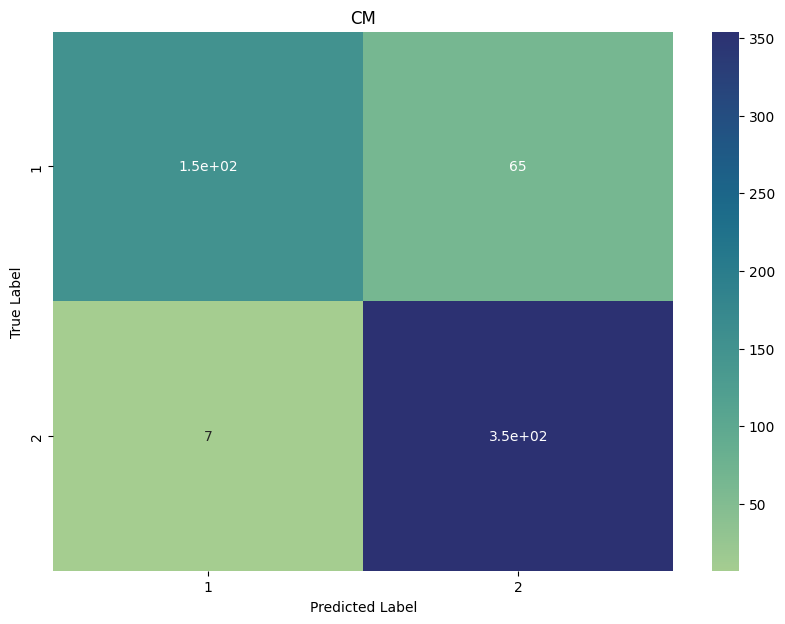

In [49]:
train_dataset, val_dataset, test_dataset = utils.load_dataset_t1()


model.load_state_dict(torch.load("A/pretrained_weights_customCNN/best_model_val_acc_j.pth"))
model.to(device)
model.eval()

test_loader = DataLoader(test_dataset, batch_size=64, shuffle= True, drop_last=True)
criterion = nn.BCELoss()

true_labels = []
predictions = []

with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for data, target in test_loader:
        data = data.cuda()
        test_output = model(data)
        target = target.cuda()
        test_loss = criterion(test_output, target)
        pred_label = torch.round(test_output)
        predictions.extend(pred_label.cpu().numpy())
        true_labels.extend(target.cpu().numpy())
        num_correct += (pred_label == target).sum().item()
        num_samples += pred_label.size(0)

    
    classes = ["1","2"]
    #roc_auc = roc_auc_score(true_labels, predictions)
    utils.plot_confusion_matrix(true_labels, predictions, classes, 'customCNN')
    print(f"test_loss:{test_loss}")
    print(f"Test Accuracy: {num_correct / num_samples:.2f}")